# Construct postage stamps for PSF explanation #

Started 2016-07-07 (WIC)

**Purpose:** Flexibly cut out postage stamps around (faint, medium, bright) stars in an HLA image.

**Eventual learning goal:** Gain practice in understanding a regime where visual appearance of objects differs from our own everyday experience.

# Setup #

In [189]:
import os
import numpy as np
from astropy.io import fits
from astropy.table import Table

In [190]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [191]:
from matplotlib import rcParams

In [192]:
plt.style.use('ggplot')

In [193]:
%matplotlib inline

In [215]:
rcParams['figure.figsize'] = (14, 16)

### Some control variables ###

In [216]:
# where are the image and star files located?
imgDir = os.getcwd()
txtDir = os.getcwd()

In [217]:
# image filename
imgFil = 'hlsp_heritage_hst_acs-wfc_m51_f435w_v1_drz_drz.fits'

In [218]:
# textfile with star coords. Comment "#" -- just x, y entries
txtFil = 'stars2.txt'

# Load and examine image, stars #

In [219]:
imgPath = '%s/%s' % (imgDir, imgFil)
txtPath = '%s/%s' % (txtDir, txtFil)

In [220]:
# load the image
aImg = fits.getdata(imgPath)
print np.shape(aImg)

(12200, 8600)


In [235]:
# load the stars
tStars = Table.read(txtPath, format='ascii')
print tStars

  X      Y     MAG 
------ ------ -----
5557.0 3670.0 15.96
6440.0 4960.0  16.9
5562.0 4321.0 18.17


### A little info for the plots ### 

In [236]:
# Some options
stampSz = [250,250]
stampSz = [200, 200]
constYrange = True
bigBright = False
readVertical = True
showTemplate = False # looks nice but doesn't show what you want it to show!
showPath = True

In [237]:
fig = plt.figure(1, figsize=(13,5))

7.65673107012
3.22125374549
1.0


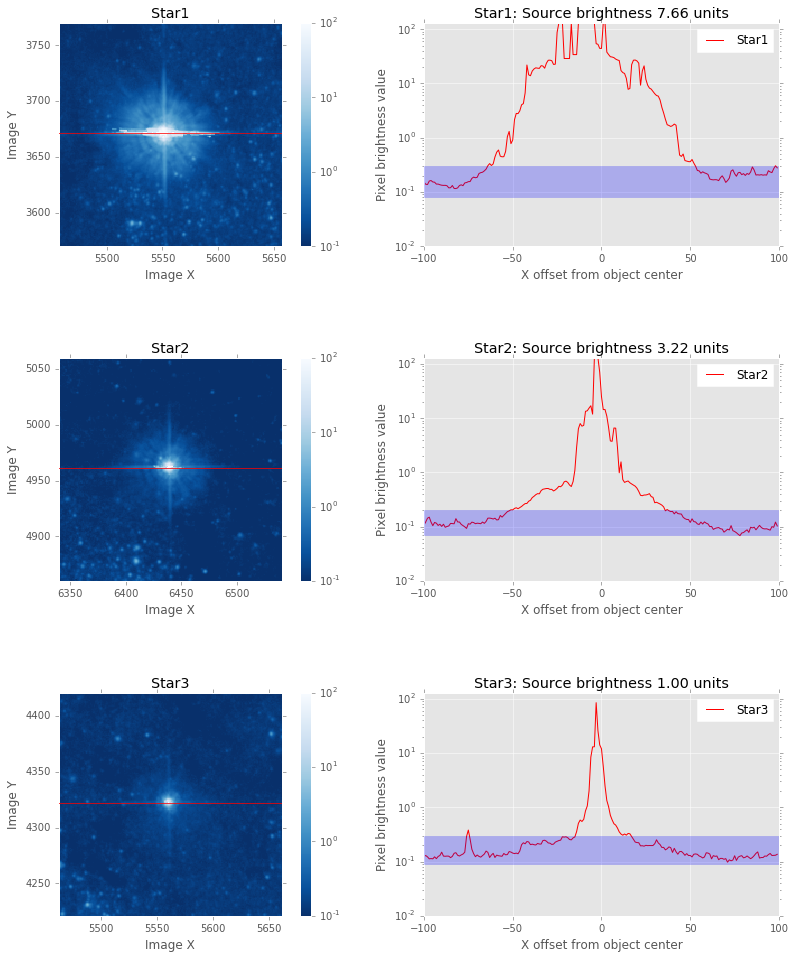

In [240]:
cmap = plt.cm.get_cmap('Blues_r')
plt.clf()

# colors for line and noise
cLine = 'r'
cNoise = 'b'

# give some space between the plots
if readVertical:
    plt.subplots_adjust(hspace=0.5, wspace=0.20)
else:
    plt.subplots_adjust(hspace=0.4, wspace=0.5)

# make the curves accessible to following loops
xCurves = []
yCurves = []
    
for iPatch in range(len(tStars)):

    # if we have it, estimate brightness
    haveBri = False
    sBri = ''
    if 'MAG' in tStars.colnames:
        thisMag = tStars['MAG'][iPatch]
        thisFlu = 2.512**(0.-thisMag + 18.17)
        print thisFlu
        sBri = ': Source brightness %.2f units' % (thisFlu)
    
    # set the postage stamp array
    xc = tStars['X'][iPatch]
    yc = tStars['Y'][iPatch]
    
    # allow stampSz to vary
    sX = 0.5*np.copy(stampSz[0])
    sY = 0.5*np.copy(stampSz[1])
    
    if iPatch < 1 and bigBright:
        sX *= 2.8
        sY *= 2.8
    
    iLo = int(xc - sX)
    iHi = int(xc + sX)
    jLo = int(yc - sY)
    jHi = int(yc + sY)

    # take a cut through
    vCut = aImg[int(yc+1), iLo:iHi]
    lCut = np.arange(np.size(vCut))+iLo
    
    # postage stamp
    if readVertical:
        plt.subplot(len(tStars), 2, iPatch*2+1)
    else:
        plt.subplot(2, len(tStars), iPatch+1)    
    extent=[iLo, iHi, jLo, jHi]
    plt.imshow(aImg[jLo:jHi, iLo:iHi], \
               norm=LogNorm(), \
               interpolation='nearest', \
              cmap=cmap, vmin=1e-1, vmax=100., origin='lower', zorder=1, \
              extent=extent)
    if showPath:
        plt.plot(lCut, np.repeat(yc+1, np.size(lCut)), zorder=5 ,color=cLine, alpha=0.75, lw=1)
    plt.xlim(iLo, iHi)
    plt.ylim(jLo, jHi)
    plt.xlabel('Image X')
    plt.ylabel('Image Y')
    plt.colorbar()
    plt.title('Star%i' % (iPatch+1))
    
    # spatial cut. Some awkwardness in the way the horizontal axis is defined
    if readVertical:
        plt.subplot(len(tStars), 2, iPatch*2+2)
    else:
        plt.subplot(2, len(tStars), iPatch + 1 + len(tStars))

    lww=1
    if showTemplate:
        lww=2
    plt.plot(lCut-xc, vCut, color=cLine, lw=lww, label='Star%i' % (iPatch+1))

    xCurves.append(lCut-xc)
    yCurves.append(vCut)
    
    # some custom limits to make this stand out a little better
    yLos = [-30., -1.0, -0.05]
    yHis = [100., 3.5, 0.7]
    
    if constYrange:
        yLowest = 1e-3
        if not showTemplate:
            yLowest = 1e-2
        yLos = np.repeat(yLowest, 3)
        yHis = np.repeat(130.,3)   # was 150
    plt.ylim(yLos[iPatch], yHis[iPatch])
    plt.xlim(iLo-xc, iHi-xc)
    
    if showTemplate:
        #if iPatch == 1:
            #plt.plot(xCurves[0], yCurves[0]*0.015 - 1., color='0.6')
            
        if iPatch == 2:
            fact = 100.  # was 100
            plt.plot(xCurves[1], yCurves[1] / fact, color='0.6', label='Star2/%i' % (fact))
            #plt.annotate('Gray thin:', \
            #             (0.02,0.17), xycoords='axes fraction', \
            #             ha='left', va='bottom', color='0.6')
            #plt.annotate('Star%i' % (fact), \
            #             (0.02,0.11), xycoords='axes fraction', \
            #            ha='left', va='bottom', color='0.6')


    l = plt.legend()
    #txt = l.get_texts()
    #txt.set_color('0.6')
    l.get_frame().set_facecolor('w')

        
    # filler for "noise" level
    alphaPoly = 0.25
    noiseLo = [0.08, 0.07, 0.09]
    noiseHi = [0.3, 0.2, 0.3]
    
    if iPatch < 1 and not constYrange:
        alphaPoly = 0.85
    
    yLo = noiseLo[iPatch]
    yHi = noiseHi[iPatch]
    
    xPoly = np.array([iLo, iHi, iHi, iLo, iLo])-xc
    yPoly = np.array([yLo, yLo, yHi, yHi, yLo])
    
    plt.fill(xPoly, yPoly, zorder=10, alpha=alphaPoly, color=cNoise)

    plt.gca().set_yscale('log')
    
    plt.xlabel('X offset from object center')
    plt.ylabel('Pixel brightness value')
    plt.title('Star%i%s' % (iPatch+1, sBri))

# save the figure to disk
plt.savefig('TEST_stamps.png')